## General information

In this kernel I work with data from APTOS 2019 Blindness Detection competition

![](https://nei.nih.gov/sites/default/files/health-images/macula_dr.gif)

Our task is to detect blindeness. This problem feels quite important for me - I'm not blind or near it, but I have a bad eyesight, so I know that problems with eye are serious.

In this kernel I'll do a basic EDA and train a baseline pytorch model.

Important: in kernel-only competitions we can't use internet connections. So I use pretrained models from here: https://www.kaggle.com/bminixhofer/pytorch-pretrained-image-models

In [1]:
# libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import cv2
import albumentations
from albumentations import torch as AT

In [2]:
def init_cudnn():
    torch.backends.cudnn.benchmark = True
    
def seed_torch(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
SEED = 777
seed_torch(SEED)
init_cudnn()
device = torch.device('cuda')

# APTOS2019

In [4]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
train['_id_code_png'] = train['id_code'].apply(lambda x: str(x)+'.png')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
test['_id_code_png'] = test['id_code'].apply(lambda x: str(x)+'.png')
sample_submission = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [5]:
train.head()

,id_code,diagnosis,_id_code_png
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


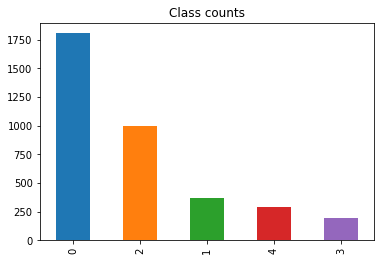

In [6]:
train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

# APTOS2015

In [7]:
os.listdir('../input/aptos-train-dataset/aptos-train-images')

['aptos-train-images']

In [8]:
train_all = pd.read_csv('../input/aptos-train-dataset/train.csv')
train_new = train_all[train_all.id_code.str.contains('.png')].reset_index(drop=True)
train_old = train_all[train_all.id_code.str.contains('.jpeg')].reset_index(drop=True)
train_old.head()

,id_code,diagnosis
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


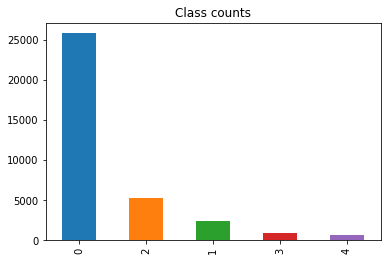

In [9]:
train_old['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

## Transforms

In [10]:
from functools import partial
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms

from albumentations import (
    Compose, HorizontalFlip, IAAAdditiveGaussianNoise, Normalize, OneOf,
    RandomBrightness, RandomContrast, Resize, VerticalFlip, Rotate, ShiftScaleRotate,
    RandomBrightnessContrast, OpticalDistortion, GridDistortion, ElasticTransform, Cutout,
    CenterCrop,
)
from albumentations.pytorch import ToTensor

In [11]:
from albumentations import ImageOnlyTransform

def crop_image_from_gray(img, tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


class CircleCrop(ImageOnlyTransform):
    def __init__(self, tol=7, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.tol = tol
    
    def apply(self, img, **params):
        img = crop_image_from_gray(img)    
    
        height, width, depth = img.shape    
    
        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))
    
        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = crop_image_from_gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        return img 
    

class CircleCropV2(ImageOnlyTransform):
    def __init__(self, tol=7, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.tol = tol
    
    def apply(self, img, **params):
        img = crop_image_from_gray(img)
        
        height, width, depth = img.shape
        largest_side = np.max((height, width))
        img = cv2.resize(img, (largest_side, largest_side))
    
        height, width, depth = img.shape    
    
        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))
    
        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = crop_image_from_gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        return img 

In [12]:
APTOS_TRAIN_DIR = Path('../input/aptos-train-dataset')
APTOS_TRAIN_IMAGES = APTOS_TRAIN_DIR / 'aptos-train-images/aptos-train-images'
APTOS_DIR = Path('../input/aptos2019-blindness-detection')

class APTOSTrainDataset(Dataset):
    def __init__(self, image_dir, file_paths, labels, transform=None):
        self.image_dir = image_dir
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = f'{self.image_dir}/{self.file_paths[idx]}'
        label = torch.tensor(self.labels[idx]).float()
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

class APTOSTestDataset(Dataset):
    def __init__(self, image_dir, file_paths, transform=None):
        self.image_dir = image_dir
        self.file_paths = file_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = f'{self.image_dir}/{self.file_paths[idx]}.png'

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image

# Grad-CAM

In [13]:
#===========================================================
# model
#===========================================================
import sys
sys.path.append('../input/efficientnet-pytorch-repository/repository/lukemelas-EfficientNet-PyTorch-50a2bf2')
from efficientnet_pytorch import EfficientNet

class ClassifierModule(nn.Sequential):
    def __init__(self, n_features):
        super().__init__(
            nn.BatchNorm1d(n_features),
            nn.Dropout(0.5),
            nn.Linear(n_features, n_features),
            nn.PReLU(),
            nn.BatchNorm1d(n_features),
            nn.Dropout(0.2),
            nn.Linear(n_features, 1),
        )


class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet-b0'):
        assert model_name in ('efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5')
        super().__init__()
        
        self.net = EfficientNet.from_name(model_name)
        n_features = self.net._fc.in_features
        
        #self.net._fc = ClassifierModule(n_features)
        self.net._fc = nn.Linear(n_features, 5)
        
    def forward(self, x):
        return self.net(x)

In [14]:
APTOS_WEIGHTS_DIR = Path('../input/aptos-weights1')
model = CustomEfficientNet('efficientnet-b5')
model.load_state_dict(torch.load(APTOS_WEIGHTS_DIR / f'efficientnet-b5_classification_2019_2015pretrained.pth'))
for name, module in model.net._modules.items():
    print(name)
final_conv = model.net._modules.get('_conv_head')
fc_params = list(model.net._modules.get('_fc').parameters())

_conv_stem
_bn0
_blocks
_conv_head
_bn1
_fc


In [15]:
def get_transforms(*, data):
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            CircleCropV2(),
            Resize(256, 256),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Rotate(p=0.5),
            RandomContrast(0.5, p=0.5),
            IAAAdditiveGaussianNoise(p=0.25),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensor(),
        ])
    
    elif data == 'valid':
        return Compose([
            CircleCropV2(),
            Resize(256, 256),
            #Normalize(
            #    mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225],
            #),
            ToTensor(),
        ])

In [16]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()


def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv[0,:, :, ].reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img


def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=8, img_size=256, device='cpu', original=False, label_heatmap=None):
    for param in model.parameters():
        param.requires_grad = False
    model.to(device)
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # original images
    if original:
        fig = plt.figure(figsize=(20, 15))
        for i, (img, target) in enumerate(train_loader):
            output = model(img.to(device))
            output = F.softmax(output.data.squeeze(), dim=0)
            pred_idx = np.argmax(output.cpu().detach().numpy())
            cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))
            ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
            plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
            ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
            if i == row*col-1:
                break
        plt.show()
    # heatmap images
    fig = plt.figure(figsize=(20, 15))
    for i, (img, target) in enumerate(train_loader):
        output = model(img.to(device))
        output = F.softmax(output.data.squeeze(), dim=0)
        pred_idx = np.argmax(output.cpu().detach().numpy())
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
        if i == row*col-1:
            break
    plt.show()
    # label heatmap images
    if label_heatmap!=None:
        fig = plt.figure(figsize=(20, 15))
        for i, (img, target) in enumerate(train_loader):
            output = model(img.to(device))
            output = F.softmax(output.data.squeeze(), dim=0)
            pred_idx = np.argmax(output.cpu().detach().numpy())
            cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))
            heatmap = getCAM(activated_features.features, weight, label_heatmap)
            ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
            plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
            plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
            ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
            if i == row*col-1:
                break
        plt.show()

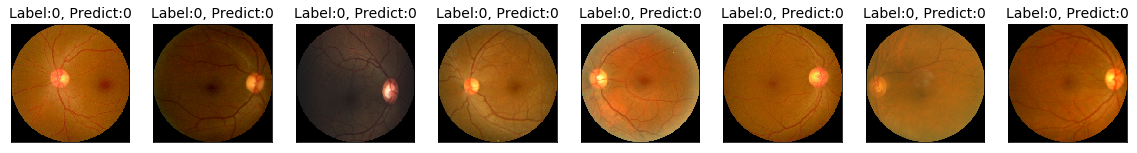

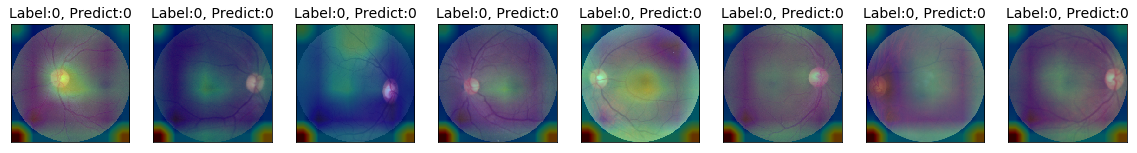

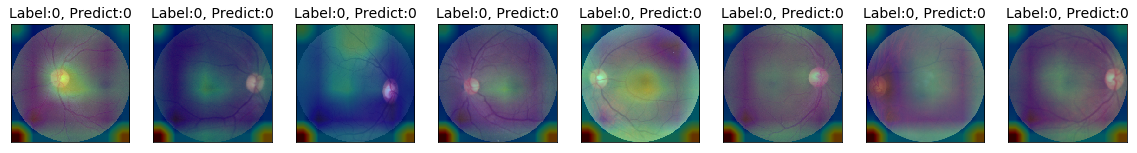

In [17]:
# prepare loader
label = 0
display_df = train[train.diagnosis==label].sample(8, random_state=SEED).reset_index(drop=True)
APTOSTrainDataset = partial(APTOSTrainDataset, image_dir=APTOS_TRAIN_IMAGES)
train_dataset = APTOSTrainDataset(file_paths=display_df._id_code_png.values,
                                  labels=display_df.diagnosis.values[:, np.newaxis],
                                  transform=get_transforms(data='valid'))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# plot GradCAM
plotGradCAM(model, final_conv, fc_params, train_loader, device='cuda', original=True, label_heatmap=label)

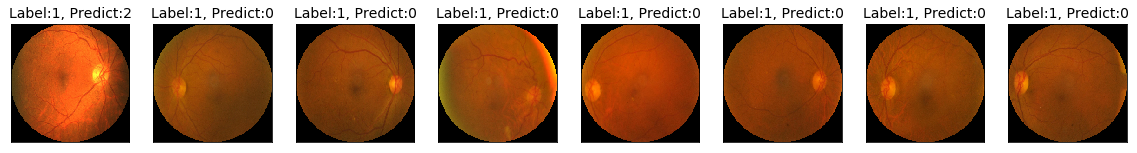

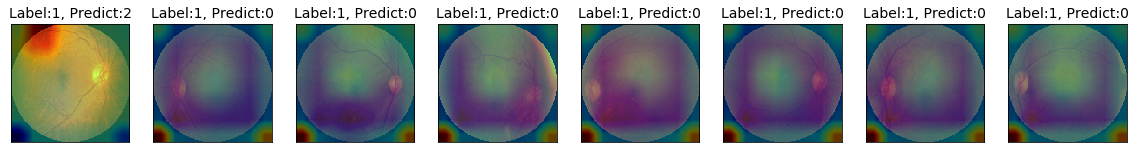

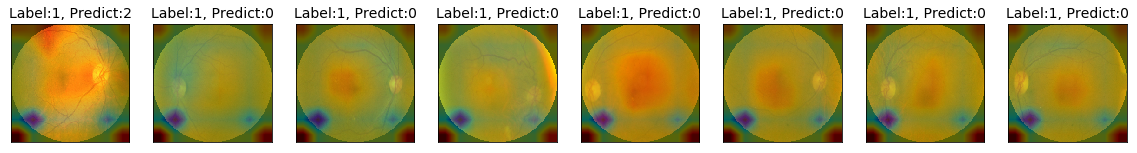

In [18]:
# prepare loader
label = 1
display_df = train[train.diagnosis==label].sample(8, random_state=SEED).reset_index(drop=True)
APTOSTrainDataset = partial(APTOSTrainDataset, image_dir=APTOS_TRAIN_IMAGES)
train_dataset = APTOSTrainDataset(file_paths=display_df._id_code_png.values,
                                  labels=display_df.diagnosis.values[:, np.newaxis],
                                  transform=get_transforms(data='valid'))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# plot GradCAM
plotGradCAM(model, final_conv, fc_params, train_loader, device='cuda', original=True, label_heatmap=label)

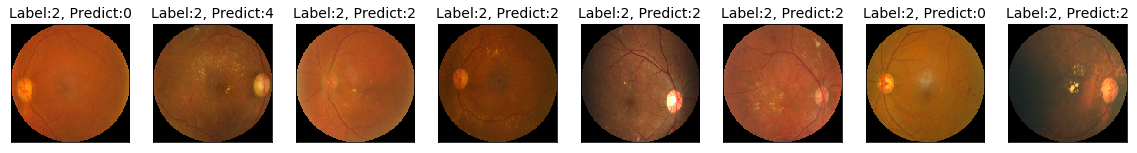

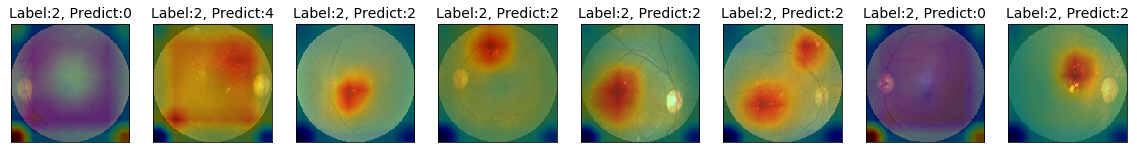

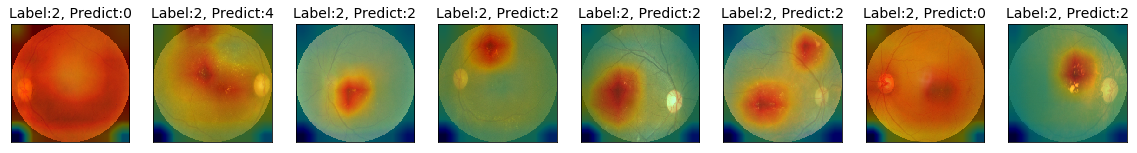

In [19]:
# prepare loader
label = 2
display_df = train[train.diagnosis==label].sample(8, random_state=SEED).reset_index(drop=True)
APTOSTrainDataset = partial(APTOSTrainDataset, image_dir=APTOS_TRAIN_IMAGES)
train_dataset = APTOSTrainDataset(file_paths=display_df._id_code_png.values,
                                  labels=display_df.diagnosis.values[:, np.newaxis],
                                  transform=get_transforms(data='valid'))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# plot GradCAM
plotGradCAM(model, final_conv, fc_params, train_loader, device='cuda', original=True, label_heatmap=label)

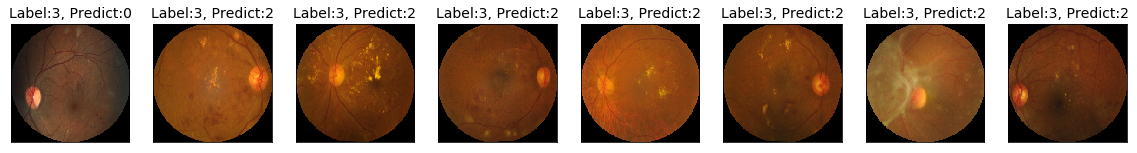

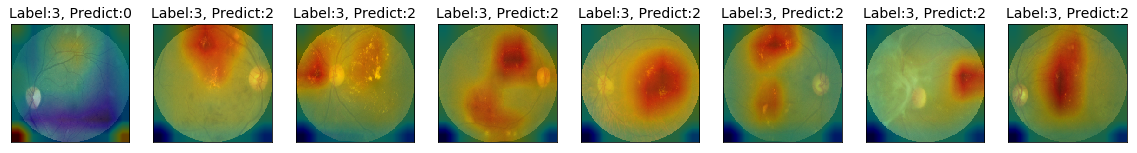

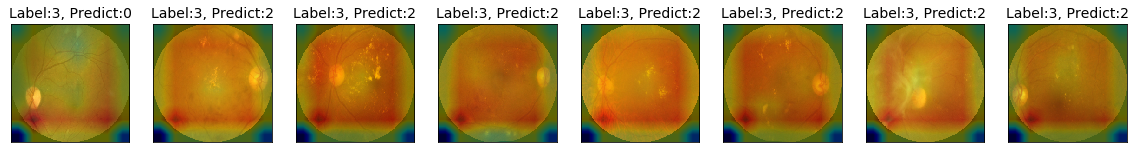

In [20]:
# prepare loader
label = 3
display_df = train[train.diagnosis==label].sample(8, random_state=1).reset_index(drop=True)
APTOSTrainDataset = partial(APTOSTrainDataset, image_dir=APTOS_TRAIN_IMAGES)
train_dataset = APTOSTrainDataset(file_paths=display_df._id_code_png.values,
                                  labels=display_df.diagnosis.values[:, np.newaxis],
                                  transform=get_transforms(data='valid'))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# plot GradCAM
plotGradCAM(model, final_conv, fc_params, train_loader, device='cuda', original=True, label_heatmap=label)

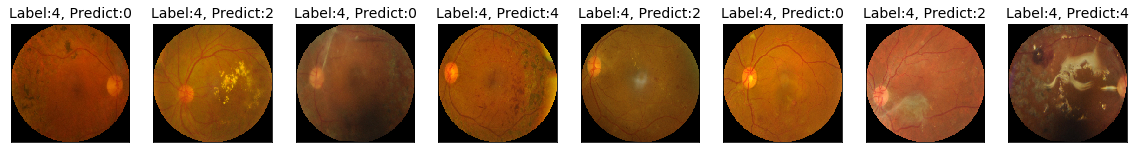

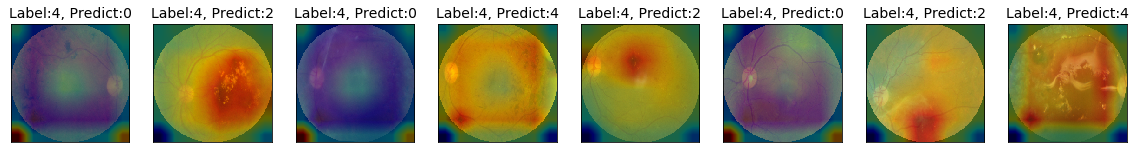

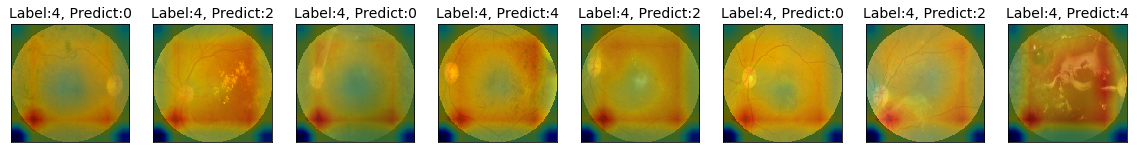

In [21]:
# prepare loader
label = 4
display_df = train[train.diagnosis==label].sample(8, random_state=0).reset_index(drop=True)
APTOSTrainDataset = partial(APTOSTrainDataset, image_dir=APTOS_TRAIN_IMAGES)
train_dataset = APTOSTrainDataset(file_paths=display_df._id_code_png.values,
                                  labels=display_df.diagnosis.values[:, np.newaxis],
                                  transform=get_transforms(data='valid'))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# plot GradCAM
plotGradCAM(model, final_conv, fc_params, train_loader, device='cuda', original=True, label_heatmap=label)